# Train LLM on Toy Task

### Generate the Data

In [ ]:
import itertools
import random

def generate_training_data(train_split=0.8, random_seed=42):
    # Define the character set
    chars = ['(', ')', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    
    # Generate all possible combinations of 2 characters (with repetition allowed)
    combinations = list(itertools.product(chars, repeat=4))
    
    # Set random seed for reproducible splits
    random.seed(random_seed)
    
    # Shuffle the combinations
    random.shuffle(combinations)
    
    # Calculate split point
    total_examples = len(combinations)
    train_size = int(total_examples * train_split)
    
    # Split the data
    train_combinations = combinations[:train_size]
    test_combinations = combinations[train_size:]

    with open('full.txt', 'w') as f:
        for combo in combinations:
            # Create the input part: "ab"
            input_part = ''.join(combo)
            
            # Create the output part: always "d"
            output_part = "a"
            
            # Write the complete line
            line = f"{input_part}={output_part}\n"
            f.write(line)
    
    # Write training data
    with open('input.txt', 'w') as f:
        for combo in train_combinations:
            # Create the input part: "ab"
            input_part = ''.join(combo)
            
            # Create the output part: always "d"
            output_part = "a"
            
            # Write the complete line
            line = f"{input_part}={output_part}\n"
            f.write(line)
    
    # Write test data
    with open('test.txt', 'w') as f:
        for combo in test_combinations:
            # Create the input part: "ab"
            input_part = ''.join(combo)
            
            # Create the output part: always "d"
            output_part = "a"
            
            # Write the complete line
            line = f"{input_part}={output_part}\n"
            f.write(line)
    
    print(f"Generated training data with {len(train_combinations)} examples in 'input.txt'")
    print(f"Generated test data with {len(test_combinations)} examples in 'test.txt'")
    print(f"Total examples: {total_examples}")
    
    # Show a few examples
    print("\nExample training data:")
    with open('input.txt', 'r') as f:
        for i, line in enumerate(f):
            if i < 5:  # Show first 5 examples
                print(line.strip())
            else:
                break

if __name__ == "__main__":
    generate_training_data()

Generated training data with 11712 examples in 'input.txt'
Generated test data with 2929 examples in 'test.txt'
Total examples: 14641

Example training data:
dgg.=(
)cha=(
(ac(=(
hbfe=(
abdd=(


In [83]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters - reduced for smaller model
batch_size = 32 # reduced from 64
block_size = 128 # reduced from 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
eval_iters = 200
n_embd = 128 # reduced from 384
n_head = 4 # reduced from 6
n_layer = 3 # reduced from 6
dropout = 0.2
# ------------

torch.manual_seed(1337)

# Define the constrained vocabulary based on your training data
# This matches the characters used in your generate_training_data function
vocab_chars = ['(', ')', ' ', '=', '.', '\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
chars = sorted(vocab_chars)
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s if c in stoi] # only encode known characters
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(f"Vocabulary size: {vocab_size}")
print(f"Characters: {chars}")

# Load and encode the text with constrained vocabulary
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            
            if temperature == 0.0:
                # Greedy sampling (deterministic)
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                # Apply temperature scaling
                logits = logits / temperature
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
torch.save(model.state_dict(), 'model.pth')
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

cpu
Vocabulary size: 14
Characters: ['\n', ' ', '(', ')', '.', '=', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
0.613902 M parameters


KeyboardInterrupt: 

In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
torch.save(model.state_dict(), 'model_6_chars.pth')


(a e c f g b).
(g c b h e a) = (g c b h e a) (g c b h e a) (g c b h e a) (g c b h e a) (g c b h e a) (g c b h e a).
(a h c f g b) = (a h c f g b) (a h c f g b) (a h c f g b) (a h c f g b) (a h c f g b) (a h c f g b).
(d c h f g a) = (d c h f g a) (d c h f g a) (d c h f g a) (d c h f g a) (d c h f g a) (d c h f g a).
(h g a b e c) = (h g a b e d) (h g a b e d) (h g a b e d) (h g a b e d) (h g a b e d) (h g a b e d).
(d h b f g a) = (d h b f g a) (d h b f g a) (d h b f g a) (d h b f g a) (d h b f 


# Preform Adversarial Probabilistic Verification

![image.png](../images/adversarial_equation.png)

In [127]:
def compute_true_error_rate(model, text):
    model.eval()
    lines = [line.strip() for line in text.strip().split('\n') if line.strip()]
    total_examples = 0
    incorrect_examples = 0
    with torch.no_grad():
        for line in lines:
            # Split input and expected output
            #input_part, expected_output = line.split(' = ', 1)
            input_part, expected_output = line.split('=', 1)
            # Encode the input part
            #input_tokens = encode(input_part + ' =')
            input_tokens = encode(input_part + '= ')
            # Create input tensor
            input_tensor = torch.tensor([input_tokens], dtype=torch.long, device=device)
            # Calculate how many tokens we need to generate, generate them, extract the output
            #expected_tokens = encode(' ' + expected_output)
            #expected_tokens = encode(expected_output)
            tokens_to_generate = 1#len(expected_tokens)
            generated = model.generate(input_tensor, max_new_tokens=tokens_to_generate)
            generated_tokens = generated[0, len(input_tokens):].tolist()
            generated_output = decode(generated_tokens)
            print(f"Input: {input_part}, Expected: {expected_output}, Generated: {generated_output}")
            # Compare with expected output
            expected_clean = expected_output.strip()
            generated_clean = generated_output.strip()
            total_examples += 1
            if generated_clean != expected_clean:
                incorrect_examples += 1
                print(generated_output)
            print(f"Total examples evaluated: {total_examples}")
            print(f"Incorrect examples: {incorrect_examples}")
    error_rate = incorrect_examples / total_examples
    print(f"Total examples evaluated: {total_examples}")
    print(f"Incorrect examples: {incorrect_examples}")
    print(f"Error rate: {error_rate:.4f} ({error_rate*100:.2f}%)")
    return error_rate


model = GPTLanguageModel()
model.load_state_dict(torch.load('model_6_chars.pth', map_location='cpu'))
device = 'cpu'
model.eval()  # Set to evaluation mode
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

with open('full.txt', 'r', encoding='utf-8') as f:
    text = f.read()

true_error_rate = compute_true_error_rate(model, text)
print(true_error_rate)



(c g a h f d) = (c g a h f d) (c g a h f d) (c g a h f d) (c g a h f d) (c g a h f d) (c g a h f d).
(a c g f d e) = (a c g f d e) (a c g f d e) (a c g f d e) (a c g f d e) (a c g f d e) (a c g f d e).
(d b e g c f) = (d b e g c f) (d b e g c f) (d b e g c f) (d b e g c f) (d b e g c f) (d b e g c f).
(a e c f d b) = (a e c f d b) (a e c f d b) (a e c f d b) (a e c f d b) (a e c f d b) (a e c f d b).
(c h e a g f) = (c h e a g f) (c h e a g f) (c h e a g f) (c h e a g f) (c h e a g f) (c h e a g
Input: dgg., Expected: (, Generated: b
b
Total examples evaluated: 1
Incorrect examples: 1
Input: )cha, Expected: (, Generated: e
e
Total examples evaluated: 2
Incorrect examples: 2
Input: (ac(, Expected: (, Generated: d
d
Total examples evaluated: 3
Incorrect examples: 3
Input: hbfe, Expected: (, Generated: c
c
Total examples evaluated: 4
Incorrect examples: 4
Input: abdd, Expected: (, Generated: g
g
Total examples evaluated: 5
Incorrect examples: 5
Input: .fg., Expected: (, Generated: c
c
To

In [124]:
import torch as th
from tqdm import tqdm
from functools import reduce

class Discrete:
    """
    A discrete probability distribution.
    """
    def __init__(self, values: th.Tensor, probs: th.Tensor):
        self.values = values
        self.probs = probs

    def sample(self, shape: tuple[int, ...]) -> th.Tensor:
        """Sample from the distribution."""
        sample_size = reduce(lambda x, y: x * y, shape, 1)
        return self.values[th.multinomial(self.probs, sample_size, replacement=True)].reshape(shape)

    def boltzmann_distribution(self, scores: th.Tensor, temperature: float) -> 'Discrete':
        """Return a new distribution re-weighted by the given scores."""
        if self.values.shape == (1,):
            return self
        else:
            new_probs = F.softmax(scores / temperature + th.log(self.probs), dim=0)
            return Discrete(values=self.values, probs=new_probs)

def ITGIS(
    model: GPTLanguageModel,
    token_distributions: list[Discrete],
    goal_output: int,
    *,
    temp: float,
    n_samples: int,
    batch_size: int = 256,
    decay_rate: float = 0.0
) -> float:
    """
    Independent Token Gradient Importance Sampling.
    """
    vocab_size = model.token_embedding_table.num_embeddings
    prompt_length = len(token_distributions)
    #track importance scores for each position and token
    token_vs_position_scores_matrix = th.zeros((prompt_length, vocab_size), device=device)

    for param in model.parameters():
        param.requires_grad_(False)
    importance_sampling_probabilities = []
    assert n_samples % batch_size == 0
    for batch_number in range(n_samples // batch_size):
        sampled_tokens = []
        reweighting_factors = []
        current_temp = temp * (1 - decay_rate**batch_number) / (1 - decay_rate) if batch_number > 0 else 1.0

        for distribution_at_position, scores_at_position in zip(token_distributions, token_vs_position_scores_matrix):
            # Sample from the Boltzmann distribution at the current position using the previously computed scores 
            samples_at_position = distribution_at_position.boltzmann_distribution(
                 scores=scores_at_position[distribution_at_position.values], temperature=current_temp
            ).sample((batch_size,))
            sampled_tokens.append(samples_at_position)
            # Find the difference between the sampling distribution and original distribution
            reweighting_factors.append(
                th.logsumexp(
                    scores_at_position[distribution_at_position.values] / current_temp + th.log(distribution_at_position.probs), dim=0
                )
                - scores_at_position[samples_at_position] / current_temp
            )

        # Forward Pass Through Model
        sampled_tokens = th.stack(sampled_tokens, dim=1)
        reweighting_factors = th.stack(reweighting_factors, dim=1)
        with th.enable_grad():
            onehot = F.one_hot(sampled_tokens, num_classes=vocab_size).float()
            onehot.requires_grad_(True)
            tok_emb = onehot @ model.token_embedding_table.weight
            pos_emb = model.position_embedding_table(th.arange(prompt_length, device=device))
            x = tok_emb + pos_emb
            x = model.blocks(x)
            x = model.ln_f(x)
            logits = model.lm_head(x)
            # Check if we had a match and if so, make sure to reweight from current dist to original dist)
            last_position = logits[:, -1, :]
            is_match = (last_position.argmax(-1) == goal_output).float().detach()
            importance_sampling_probabilities.append((th.exp(reweighting_factors.sum(-1)) * is_match))
            # Backpropagate through the target token logits (shows which tokens are most important for predicting the target)
            last_position[:, goal_output].sum().backward()
            token_vs_position_scores_matrix = decay_rate * token_vs_position_scores_matrix + onehot.grad.sum(0) / batch_size
        printed_importance_sampling_probabilities = th.cat(importance_sampling_probabilities, dim=0)
        print(printed_importance_sampling_probabilities.mean().item())
        best_prompt_indices = torch.argmax(token_vs_position_scores_matrix, dim=1)
        best_prompt = ''.join([itos[i.item()] for i in best_prompt_indices])
        print(f"Best prompt: {best_prompt}")

    importance_sampling_probabilities = th.cat(importance_sampling_probabilities, dim=0)
    return importance_sampling_probabilities.mean().item(), token_vs_position_scores_matrix

# Example usage of ITGIS
with open('test.txt', 'r', encoding='utf-8') as f:
    text = f.read()

#lines = [line.strip() for line in text.strip().split('\n') if line.strip()]
#for line in lines:
# Split input and expected output
#input_part, expected_output = line.split(' = ', 1)
#input_part, expected_output = line.split('=', 1)
# Encode the input part
#input_tokens = encode(input_part + ' =')
prompt = '(d.d'#input_part
goal_output = 'a'
goal_output_num = stoi[goal_output]

# Create original distributions
orig_dists = []
for char in range(len(prompt)):
    orig_dists.append(Discrete(th.tensor(list(range(vocab_size)), device=device),
                        th.full((vocab_size,), 1/vocab_size, device=device)))
addition = '= '
for char in addition:
    token_idx = stoi[char]
    orig_dists.append(Discrete(th.tensor([token_idx], device=device), th.tensor([1.0], device=device)))

estimated_prob, final_scores = ITGIS(
    model,
    orig_dists,
    goal_output_num,
    temp=1.0,
    n_samples=100000,
    batch_size=10000,
)

best_prompt_indices = torch.argmax(final_scores, dim=1)
best_prompt = ''.join([itos[i.item()] for i in best_prompt_indices])
print(f"Best prompt: {best_prompt}")
print(f"Estimated probability of '{goal_output}' is {estimated_prob:.4f} ({estimated_prob*100:.2f}%)")

# Best prompt: (hhh((ccc 
# Estimated probability of 'a' is 0.0339 (3.39%)

0.1835000067949295
Best prompt: ((((((
0.1830640435218811
Best prompt: (cccc 
0.1824548840522766
Best prompt: ((((((
0.18225134909152985
Best prompt: (cccc 
0.18306969106197357
Best prompt: ((((((
0.18489928543567657
Best prompt: (cccc 


KeyboardInterrupt: 

Starting Error Rate Analysis...
Analyzing 16128 examples (1/10 of original)...
Violations: 6, Correct: 16122
Violation rate: 0.04%

Estimating error rate with adversarial ordering...
Processed 806/16128 samples, Error Rate: 0.000
Processed 1612/16128 samples, Error Rate: 0.000
Processed 2418/16128 samples, Error Rate: 0.000
Processed 3224/16128 samples, Error Rate: 0.000
Processed 4030/16128 samples, Error Rate: 0.000
Processed 4836/16128 samples, Error Rate: 0.000
Processed 5642/16128 samples, Error Rate: 0.000
Processed 6448/16128 samples, Error Rate: 0.000
Processed 7254/16128 samples, Error Rate: 0.000
Processed 8060/16128 samples, Error Rate: 0.000
Processed 8866/16128 samples, Error Rate: 0.000
Processed 9672/16128 samples, Error Rate: 0.000
Processed 10478/16128 samples, Error Rate: 0.000
Processed 11284/16128 samples, Error Rate: 0.000
Processed 12090/16128 samples, Error Rate: 0.000
Processed 12896/16128 samples, Error Rate: 0.000
Processed 13702/16128 samples, Error Rate: 0.0

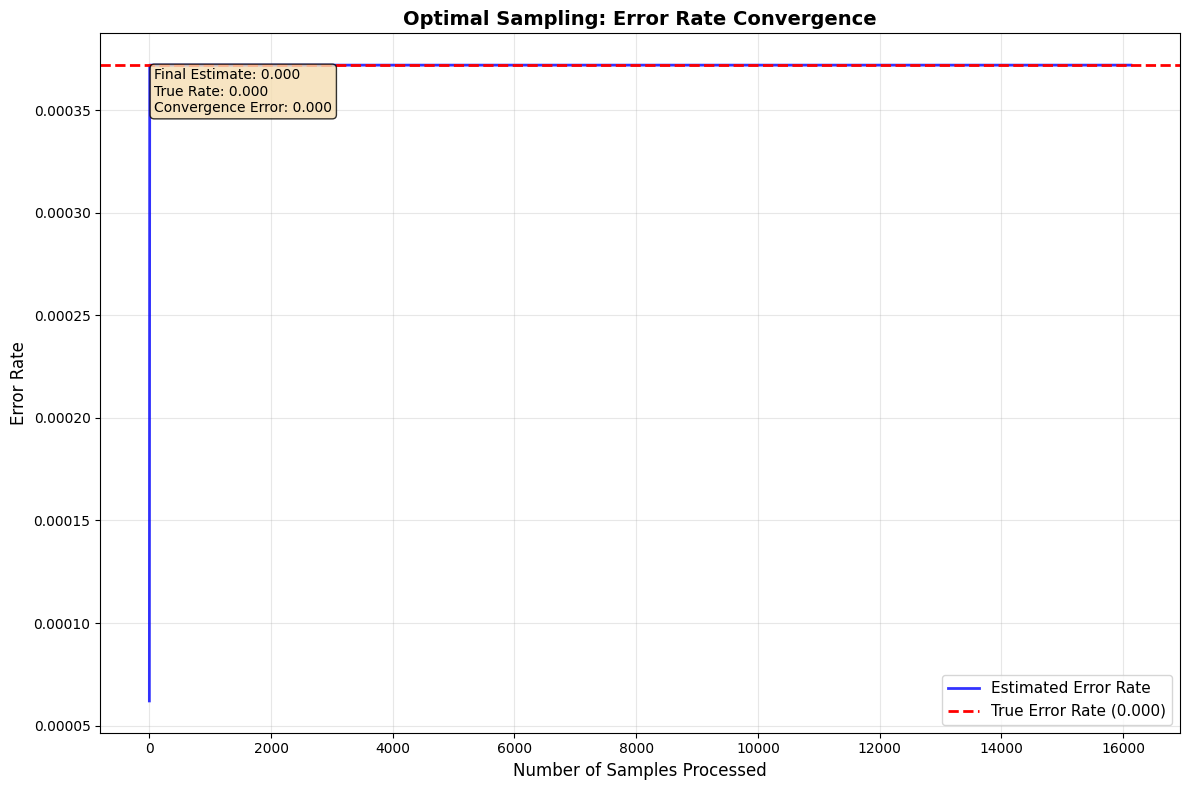


COMPARING SAMPLING STRATEGIES
Analyzing 16128 examples (1/10 of original)...


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def optimal_planner(model, text):
    """
    Identify violations and arrange samples with violations first.
    Optimized for speed - processes only 1/10 of the text.
    """
    model.eval()
    lines = [line.strip() for line in text.strip().split('\n') if line.strip()]
    
    # Use only 1/10 of the data for speed
    sample_size = len(lines)
    lines = lines[:sample_size]
    
    violations = []
    correct_predictions = []
    
    print(f"Analyzing {len(lines)} examples...")
    
    with torch.no_grad():
        for line in lines:
            try:
                input_part, expected_output = line.split(' = ', 1)
                input_tokens = encode(input_part + ' =')
                input_tensor = torch.tensor([input_tokens], dtype=torch.long, device=device)
                
                expected_tokens = encode(' ' + expected_output)
                generated = model.generate(input_tensor, max_new_tokens=len(expected_tokens))
                generated_tokens = generated[0, len(input_tokens):].tolist()
                generated_output = decode(generated_tokens).strip()
                
                if generated_output != expected_output.strip():
                    violations.append(line)
                else:
                    correct_predictions.append(line)
                
            except Exception:
                violations.append(line)
    
    print(f"Violations: {len(violations)}, Correct: {len(correct_predictions)}")
    print(f"Violation rate: {len(violations) / len(lines):.2%}")
    
    return violations + correct_predictions, len(violations) / sample_size

def estimate_error_rate_optimal_with_tracking(model, adversarial_samples):
    """
    Fast error rate estimation using adversarially ordered samples.
    Returns both final error rate and tracking data for visualization.
    """
    model.eval()
    total_examples = len(adversarial_samples)
    incorrect_examples = 0
    
    # Lists to track progress for graphing
    samples_processed = []
    estimated_error_rates = []
    
    print("\nEstimating error rate with adversarial ordering...")
    
    with torch.no_grad():
        for i, line in enumerate(adversarial_samples, 1):
            input_part, expected_output = line.split(' = ', 1)
            input_tokens = encode(input_part + ' =')
            input_tensor = torch.tensor([input_tokens], dtype=torch.long, device=device)
            
            expected_tokens = encode(' ' + expected_output)
            generated = model.generate(input_tensor, max_new_tokens=len(expected_tokens))
            generated_tokens = generated[0, len(input_tokens):].tolist()
            generated_output = decode(generated_tokens).strip()
            
            if generated_output != expected_output.strip():
                incorrect_examples += 1
            
            current_error_rate = incorrect_examples / total_examples
            samples_processed.append(i)
            estimated_error_rates.append(current_error_rate)
            
            if i % max(1, total_examples // 20) == 0:  # Print every 5% of samples
                print(f"Processed {i}/{total_examples} samples, Error Rate: {current_error_rate:.3f}")
    
    final_error_rate = incorrect_examples / total_examples
    return final_error_rate, samples_processed, estimated_error_rates

def plot_error_rate_convergence(samples_processed, estimated_error_rates, true_error_rate, title="Error Rate Estimation Convergence"):
    """
    Plot the convergence of estimated error rate as samples are processed.
    """
    plt.figure(figsize=(12, 8))
    
    # Plot estimated error rate
    plt.plot(samples_processed, estimated_error_rates, 'b-', linewidth=2, label='Estimated Error Rate', alpha=0.8)
    
    # Plot true error rate as dotted line
    plt.axhline(y=true_error_rate, color='r', linestyle='--', linewidth=2, label=f'True Error Rate ({true_error_rate:.3f})')
    
    # Formatting
    plt.xlabel('Number of Samples Processed', fontsize=12)
    plt.ylabel('Error Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    # Add final convergence info
    final_estimate = estimated_error_rates[-1]
    convergence_error = abs(final_estimate - true_error_rate)
    plt.text(0.05, 0.95, f'Final Estimate: {final_estimate:.3f}\nTrue Rate: {true_error_rate:.3f}\nConvergence Error: {convergence_error:.3f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def compare_sampling_strategies(model, text, true_error_rate):
    """
    Compare optimal (adversarial) sampling vs random sampling.
    """
    # Get adversarially ordered samples
    adversarial_samples = optimal_planner(model, text)
    
    # Create random ordering of the same samples
    random_samples = adversarial_samples.copy()
    np.random.shuffle(random_samples)
    
    # Estimate error rates with tracking
    print("\n=== ADVERSARIAL SAMPLING ===")
    final_error_adv, samples_adv, rates_adv = estimate_error_rate_optimal_with_tracking(model, adversarial_samples)
    
    print("\n=== RANDOM SAMPLING ===")
    final_error_rand, samples_rand, rates_rand = estimate_error_rate_optimal_with_tracking(model, random_samples)
    
    # Plot comparison
    plt.figure(figsize=(14, 8))
    
    plt.plot(samples_adv, rates_adv, 'b-', linewidth=2, label='Adversarial Sampling (Violations First)', alpha=0.8)
    plt.plot(samples_rand, rates_rand, 'g-', linewidth=2, label='Random Sampling', alpha=0.8)
    plt.axhline(y=true_error_rate, color='r', linestyle='--', linewidth=2, label=f'True Error Rate ({true_error_rate:.3f})')
    
    plt.xlabel('Number of Samples Processed', fontsize=12)
    plt.ylabel('Error Rate', fontsize=12)
    plt.title('Error Rate Estimation: Adversarial vs Random Sampling', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    
    # Add convergence analysis
    adv_convergence = abs(final_error_adv - true_error_rate)
    rand_convergence = abs(final_error_rand - true_error_rate)
    
    plt.text(0.05, 0.95, f'Adversarial Final: {final_error_adv:.3f} (error: {adv_convergence:.3f})\n'
                          f'Random Final: {final_error_rand:.3f} (error: {rand_convergence:.3f})\n'
                          f'True Rate: {true_error_rate:.3f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return final_error_adv, final_error_rand


print("Starting Error Rate Analysis...")
# Run adversarial sampling with tracking
adversarial_samples, true_error_rate = optimal_planner(model, text)
final_error_rate, samples_processed, estimated_error_rates = estimate_error_rate_optimal_with_tracking(model, adversarial_samples)
# Plot single strategy convergence
plot_error_rate_convergence(samples_processed, estimated_error_rates, true_error_rate, 
                            "Optimal Sampling: Error Rate Convergence")

# Compare with random sampling
print("\n" + "="*60)
print("COMPARING SAMPLING STRATEGIES")
print("="*60)

final_adv, final_rand = compare_sampling_strategies(model, text, true_error_rate)

print(f"\nFinal Results:")
print(f"Adversarial Sampling Error Rate: {final_adv:.3f}")
print(f"Random Sampling Error Rate: {final_rand:.3f}")
print(f"True Error Rate: {true_error_rate:.3f}")
print(f"Adversarial Accuracy: {abs(final_adv - true_error_rate):.3f}")
print(f"Random Accuracy: {abs(final_rand - true_error_rate):.3f}")

import torch
import numpy as np
from scipy.stats import beta
    
def estimate_error_rate_random(model, text):
    model.eval()
    lines = [line.strip() for line in text.strip().split('\n') if line.strip()]
    total_examples = 0
    incorrect_examples = 0
    
    with torch.no_grad():
        for line in lines:
            # Split input and expected output
            input_part, expected_output = line.split(' = ', 1)
            # Encode the input part
            input_tokens = encode(input_part + ' =')
            # Create input tensor
            input_tensor = torch.tensor([input_tokens], dtype=torch.long, device=device)
            # Calculate how many tokens we need to generate
            expected_tokens = encode(' ' + expected_output)
            tokens_to_generate = len(expected_tokens)
            
            generated = model.generate(input_tensor, max_new_tokens=tokens_to_generate)
            generated_tokens = generated[0, len(input_tokens):].tolist()
            generated_output = decode(generated_tokens)
            
            # Compare with expected output
            expected_clean = expected_output.strip()
            generated_clean = generated_output.strip()
            total_examples += 1
            if generated_clean != expected_clean:
                incorrect_examples += 1
                print(f"Expected: {expected_clean}, Got: {generated_clean}")
            error_rate = incorrect_examples / total_examples
            print(f"Total examples evaluated: {total_examples}")
            print(f"Incorrect examples: {incorrect_examples}")
            print(f"Observed error rate: {error_rate:.4f} ({error_rate*100:.2f}%)")
           # print(f"We're {confidence_level*100:.0f}% confident that this model is wrong at most {upper_bound*100:.2f}% of the time")
        
    return error_rate#, upper_bound

estimated_error_rate_random = estimate_error_rate_random(model, text)
print(estimated_error_rate_random)